# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# я смог скачать датасет только с Kaggle, а там X и Y уже joined
df_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/samsung_train.csv")
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/samsung_test.csv")

X_train = df_train.drop(columns=["Activity", "subject"])
y_train = df_train["Activity"]

X_test = df_test.drop(columns=["Activity", "subject"])
y_test = df_test["Activity"]

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [28]:
dict(zip(le.classes_, range(len(le.classes_))))

{'LAYING': 0,
 'SITTING': 1,
 'STANDING': 2,
 'WALKING': 3,
 'WALKING_DOWNSTAIRS': 4,
 'WALKING_UPSTAIRS': 5}

In [10]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [11]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [12]:
np.unique(y) # чуть другие метки чем в описании ниже но это кажется не критично

array([0, 1, 2, 3, 4, 5])

In [13]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [14]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [15]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [16]:
X_pca.shape[1]

65

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [22]:
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

round(float(pca_full.explained_variance_ratio_[0]), 2) * 100

51.0

Визуализируйте данные в проекции на первые две главные компоненты.

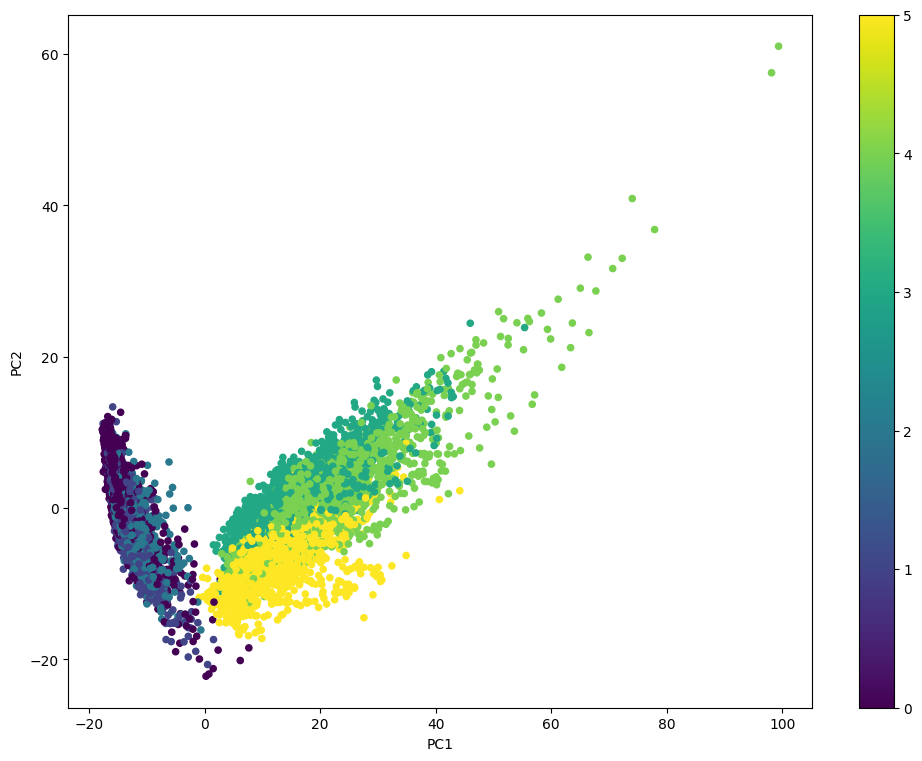

In [23]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице – синие цвета) и (сидение, стояние, лежание – зелено-желтые цвета)**

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [24]:
kmeans = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)

cluster_labels = kmeans.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

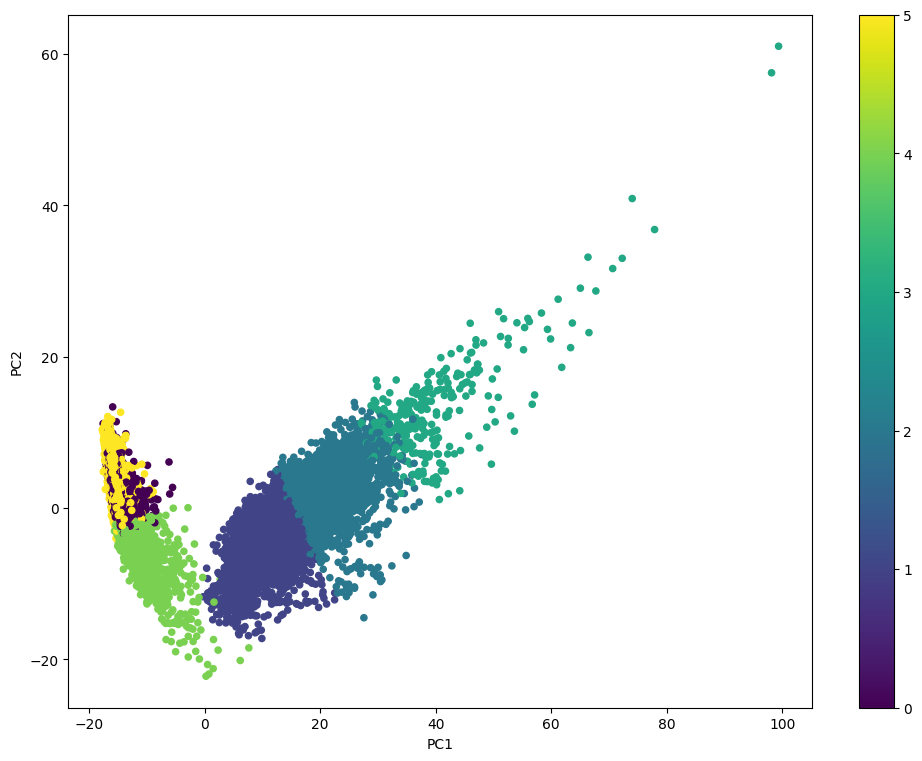

In [25]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()


Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [26]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,52,5,0,0,329,1558,1944
подъем вверх по лестнице,1235,1,0,0,450,91,1777
спуск по лестнице,1344,0,0,0,562,0,1906
сидение,0,903,741,78,0,0,1722
стояние,0,320,890,196,0,0,1406
лежание,0,1241,296,5,2,0,1544
все,2631,2470,1927,279,1343,1649,10299


In [35]:
tab_no_margins = tab.iloc[:-1, :-1]
fractions = tab_no_margins.max(axis=1) / tab_no_margins.sum(axis=1)

fractions.idxmax(), fractions.max()

('лежание', 0.8037564766839378)

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

**перечисленные варианты не подходят**

лучше всего отделилось лежание

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [37]:
inertia = []

for k in tqdm_notebook(range(1, n_classes + 1)):
    km = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=RANDOM_STATE
    )
    km.fit(X_pca)
    inertia.append(km.inertia_)

/tmp/ipython-input-180263494.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

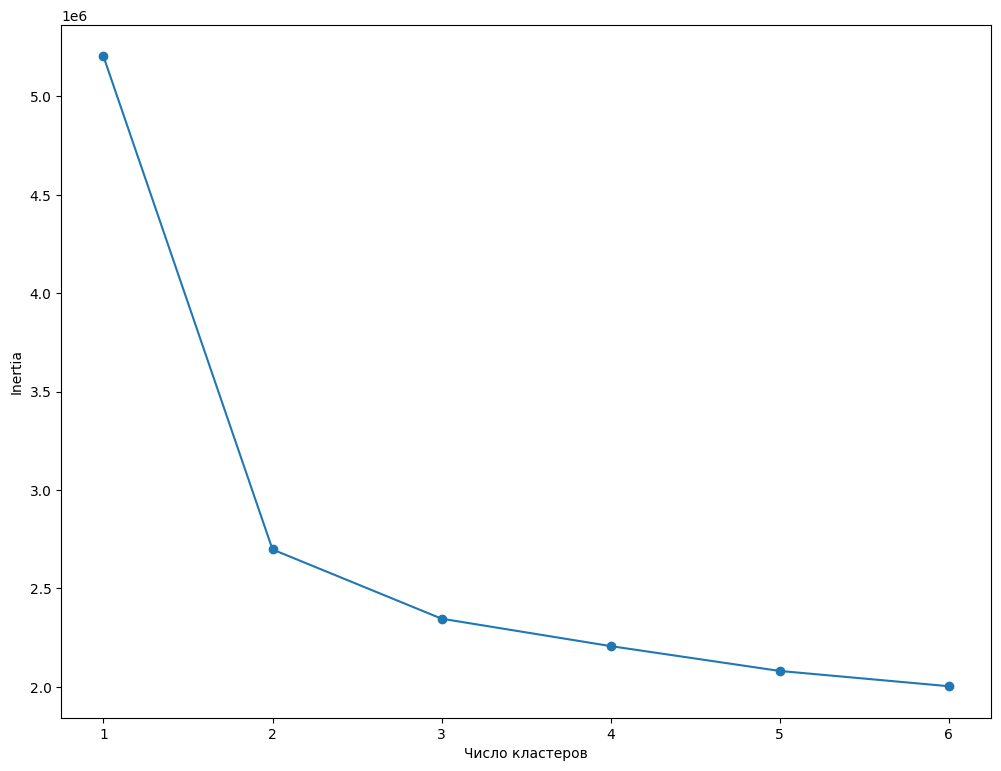

In [38]:
plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.show()


**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

**Ответ 2**

Согласно методу локтя, оптимальное число кластеров равно 2, так как при переходе от 1 к 2 кластерам наблюдается резкое уменьшение inertia, а дальнейшее увеличение числа кластеров приводит лишь к незначительным улучшениям.

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [39]:
ag = AgglomerativeClustering(
    n_clusters=n_classes,
    linkage='ward'
)

ag_labels = ag.fit_predict(X_pca)

(0.4198070012602345, 0.49362763373004886)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [40]:
ari_kmeans = metrics.adjusted_rand_score(y, cluster_labels)
ari_ag = metrics.adjusted_rand_score(y, ag_labels)

ari_kmeans, ari_ag


(0.4198070012602345, 0.49362763373004886)

**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

Ответ

- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [43]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [44]:
grid = GridSearchCV(svc, svc_params, cv=3)
grid.fit(X_train_scaled, y_train)

best_svc = grid.best_estimator_

In [46]:
grid.best_params_

{'C': 0.1}

**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

**Ответ 0.1**

In [47]:
y_predicted = best_svc.predict(X_test_scaled)

In [48]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,526,0,11,0,0,0,537
подъем вверх по лестнице,0,426,61,0,0,4,491
спуск по лестнице,0,15,517,0,0,0,532
сидение,0,0,0,494,0,2,496
стояние,0,1,0,2,413,4,420
лежание,0,0,0,12,0,459,471
все,526,442,589,508,413,469,2947


In [49]:
from sklearn.metrics import classification_report

report = classification_report(
    y_test,
    y_predicted,
    output_dict=True
)

report_df = pd.DataFrame(report).T
report_df


,precision,recall,f1-score,support
0,1.000000,0.979516,0.989652,537.000000
1,0.963801,0.867617,0.913183,491.000000
2,0.877759,0.971805,0.922391,532.000000
3,0.972441,0.995968,0.984064,496.000000
4,1.000000,0.983333,0.991597,420.000000
5,0.978678,0.974522,0.976596,471.000000
accuracy,0.961995,0.961995,0.961995,0.961995
macro avg,0.965446,0.962127,0.962914,2947.000000
weighted avg,0.963855,0.961995,0.962019,2947.000000


In [53]:
worst_precision = report_df['precision'].idxmin()
worst_recall = report_df['recall'].idxmin()

worst_precision, worst_recall

('2', '1')

In [54]:
dict(zip(le.classes_, range(len(le.classes_))))

{'LAYING': 0,
 'SITTING': 1,
 'STANDING': 2,
 'WALKING': 3,
 'WALKING_DOWNSTAIRS': 4,
 'WALKING_UPSTAIRS': 5}

**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

- **На моих данных худшая точность – стояние**
- **Худшая полнота – сидение**

In [55]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
grid_pca = GridSearchCV(svc, svc_params, cv=3)
grid_pca.fit(X_train_pca, y_train)

GridSearchCV(cv=3, estimator=LinearSVC(max_iter=10000, random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

3.971628961662199

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


In [59]:
round(float(grid.best_score_ - grid_pca.best_score_) * 100)

4

**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Ответ**

- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.